# Autism Prediction - Model Creation using TensorFlow and MobileNet

## Import Libraries

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory 

## Explore dataset 

In [11]:
dir = r'./autism_dataset/'
train_dir = os.path.join(dir,'train')
test_dir = os.path.join(dir,'test')
val_dir = os.path.join(dir,'valid')
print(train_dir)

./autism_dataset/train


In [14]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2538 files belonging to 2 classes.


In [15]:
test_dataset = image_dataset_from_directory(test_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 200 files belonging to 2 classes.


In [17]:
valid_dataset = image_dataset_from_directory(val_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 200 files belonging to 2 classes.


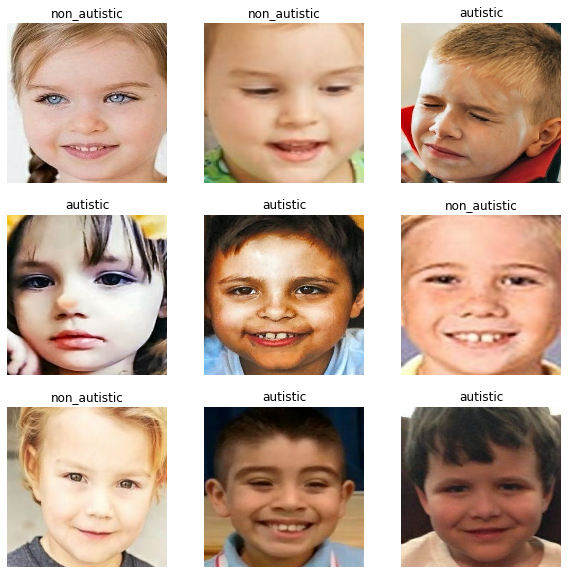

In [18]:
##shows first 9 images from training dataset

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [20]:
## use buffered prefetching to load images from disk 
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
##removing duipplicates 

tf.data.experimental.unique()


In [21]:
## data augmentation: adds sample diversity 
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

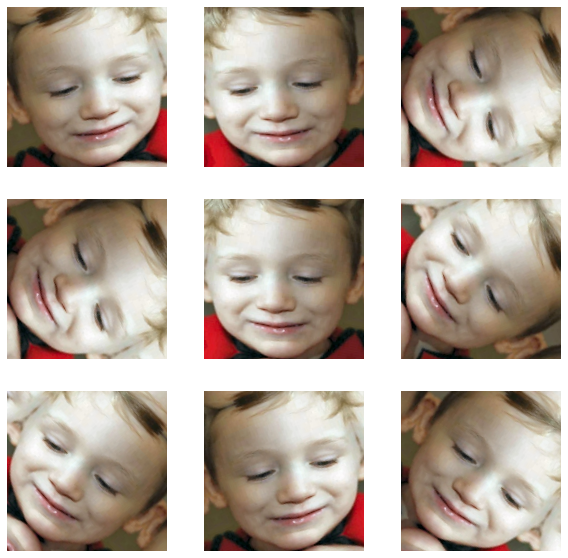

In [22]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [24]:
#reescale pixel values
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


### Create base model using mobilenet_v2

In [54]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

94773248/94765736 [==============================] - 6s 0us/step


In [55]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


## feature extraction

In [56]:
base_model.trainable = False


In [57]:
base_model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [30]:
#add a classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [31]:
#applys a layer to convert features into single prediction per image
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [32]:
#builds model based on current.
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [34]:
#compile model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [36]:
len(model.trainable_variables)


2

In [37]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

7/7 [==============================] - 9s 727ms/step - loss: 0.7674 - accuracy: 0.5000


In [38]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.77
initial accuracy: 0.50


In [39]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
80/80 [==============================] - 80s 928ms/step - loss: 0.7549 - accuracy: 0.5205 - val_loss: 0.7429 - val_accuracy: 0.5000
Epoch 2/10
80/80 [==============================] - 72s 888ms/step - loss: 0.7000 - accuracy: 0.5729 - val_loss: 0.7124 - val_accuracy: 0.5450
Epoch 3/10
80/80 [==============================] - 72s 885ms/step - loss: 0.6675 - accuracy: 0.5973 - val_loss: 0.6948 - val_accuracy: 0.5700
Epoch 4/10
80/80 [==============================] - 74s 914ms/step - loss: 0.6453 - accuracy: 0.6308 - val_loss: 0.6780 - val_accuracy: 0.5950
Epoch 5/10
80/80 [==============================] - 65s 812ms/step - loss: 0.6302 - accuracy: 0.6430 - val_loss: 0.6685 - val_accuracy: 0.6100
Epoch 6/10
80/80 [==============================] - 54s 671ms/step - loss: 0.6161 - accuracy: 0.6525 - val_loss: 0.6619 - val_accuracy: 0.6050
Epoch 7/10
80/80 [==============================] - 55s 673ms/step - loss: 0.5903 - accuracy: 0.6749 - val_loss: 0.6522 - val_accuracy: 0.6250

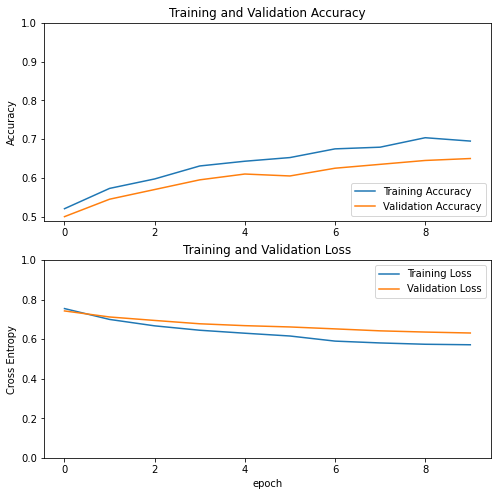

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [41]:
## fine tuning 

In [42]:
base_model.trainable = True


In [43]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [44]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [45]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [47]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
80/80 [==============================] - 77s 959ms/step - loss: 0.3744 - accuracy: 0.8247 - val_loss: 0.4694 - val_accuracy: 0.7700
Epoch 11/20
80/80 [==============================] - 76s 939ms/step - loss: 0.3787 - accuracy: 0.8195 - val_loss: 0.6069 - val_accuracy: 0.6750
Epoch 12/20
80/80 [==============================] - 75s 932ms/step - loss: 0.3706 - accuracy: 0.8258 - val_loss: 0.4186 - val_accuracy: 0.8000
Epoch 13/20
80/80 [==============================] - 265s 3s/step - loss: 0.3585 - accuracy: 0.8247 - val_loss: 0.4700 - val_accuracy: 0.7500
Epoch 14/20
80/80 [==============================] - 121s 1s/step - loss: 0.3553 - accuracy: 0.8329 - val_loss: 0.4123 - val_accuracy: 0.8200
Epoch 15/20
80/80 [==============================] - 80s 997ms/step - loss: 0.3463 - accuracy: 0.8385 - val_loss: 0.4019 - val_accuracy: 0.8200
Epoch 16/20
80/80 [==============================] - 78s 970ms/step - loss: 0.3463 - accuracy: 0.8416 - val_loss: 0.4075 - val_accuracy: 0.8

In [48]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']



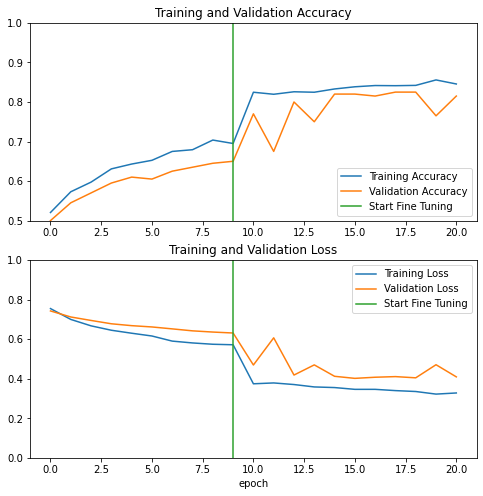

In [50]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [51]:
## evaluating performance

In [52]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

7/7 [==============================] - 4s 520ms/step - loss: 0.3525 - accuracy: 0.8450
Test accuracy : 0.8450000286102295


Predictions:
 [0 1 1 0 0 1 1 0 1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1]
Labels:
 [0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 1 1]


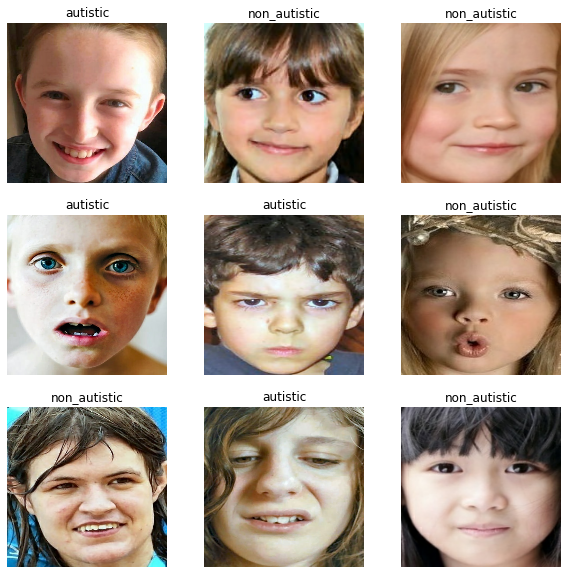

In [53]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")